# COVID binary classification
In this *notebook* we design a ConvNet to binary classification COVID-19 images.The model distinguishes between covid patient radiographs and others (pneumonia patients and healthy people). The deep model is an inception net, with five inception blocks. Each block has four convolutional layers with filters of 1x1,1x1, 3x3 and 5x5, also the block has MaxPooling layers before the convolutional layers. 

The dataset contains very little images of COVID patients, specifically 87 in the train set and only 10 to test, for this reason, we use the SMOTE Algorithm to generate new samples of COVID images.

In [1]:
__author__ = '@iRodGit'
import numpy as np
import pandas as pd
import os
from PIL import Image
import keras
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.layers import Dense, Dropout, Activation, Flatten, Input, Add
from keras.layers import AveragePooling2D, Conv2D, MaxPooling2D, concatenate # Concatenate
from keras.models import Sequential, Model
from keras.utils import to_categorical
from codvidutils.imageproc import map_categorical

Using TensorFlow backend.


## Load and pre-processing data

In [2]:
train_class = pd.read_csv('data/train_split_v2.txt', sep=' ', header=None, names=['patientID', 'image_path', 'class'])
test_class = pd.read_csv('data/test_split_v2.txt', sep=' ', header=None, names=['patientID', 'image_path', 'class'])

In [3]:
train_pics = []
for img in train_class['image_path'].values:
    train_pics.append(np.array(Image.open('data/train/' + img))[:, :,:3])
test_pics = []
for img in test_class['image_path'].values:
    test_pics.append(np.array(Image.open('data/test/' + img))[:, :, :3])

In [22]:
def new_pictures(picture, strides=5, kernel=(180,180)):
    news = []
    for i in range(int((picture.shape[0]-kernel[0])/strides)+1):
        for j in range(int((picture.shape[1]-kernel[1])/strides)+1):
            s,k = strides*i, strides*j
            print(s,k)
            news.append(picture[s:kernel[0]+s,k:kernel[1]+k])
    
    return news

In [15]:
def new_pictures_arrays(pictures, strides=5, kernel=(180,180)):
    news = []
    for i in range(int((pictures.shape[1]-kernel[0])/strides)+1):
        for j in range(int((pictures.shape[2]-kernel[1])/strides)+1):
            s,k = strides*i, strides*j
            news.append(pictures[:,s:kernel[0]+s,k:kernel[1]+k])
    news= np.array(news)
    
    return news.reshape(news.shape[0]*news.shape[1], kernel[0],kernel[1],pictures.shape[3])

In [5]:
values_dict = {'COVID-19': 1,'pneumonia': 2,'normal': 0}
test_class['class_categorical'] = test_class['class'].apply(map_categorical, args=(values_dict,))
train_class['class_categorical'] = train_class['class'].apply(map_categorical, args=(values_dict,))

In [6]:
X_train = np.array(train_pics)
del train_pics
X_test = np.array(test_pics)
del test_pics
diseaseID_train = np.asarray(train_class["class_categorical"])
diseaseID_test = np.asarray(test_class["class_categorical"])
print('Train shape X: {},  Y: {} \n Test shape X: {}, Y: {}'.format(X_train.shape, diseaseID_train.shape, X_test.shape, diseaseID_test.shape))

Train shape X: (16574, 200, 200, 3),  Y: (16574,) 
 Test shape X: (1953, 200, 200, 3), Y: (1953,)


In [70]:
s = ndimage.rotate(X_test[diseaseID_test==0],-6,reshape= False, axes=[1,2])
s.shape

(885, 200, 200, 3)

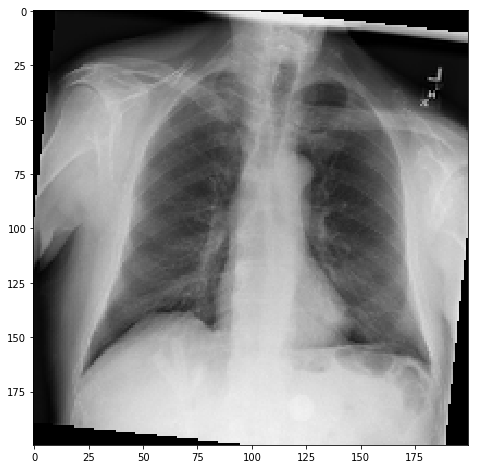

In [73]:
fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(8,8))#,
plt.imshow(s[500])

(200, 200, 3)


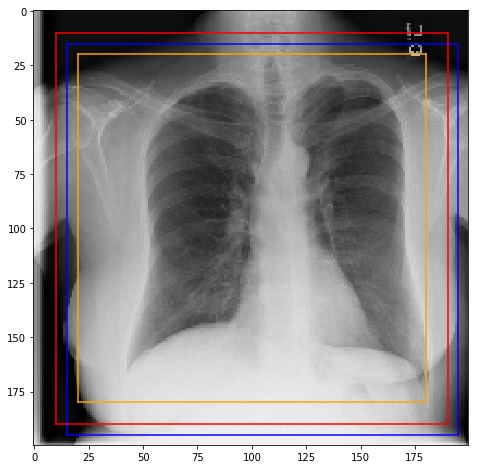

In [96]:
from scipy import ndimage
a = X_test[diseaseID_test==0][5]
print(a.shape)
fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(8,8))#,
rotate_face = ndimage.rotate(a, -0,reshape=False)
plt.imshow(rotate_face)


plt.plot([15,195],[15,15],color="blue")
plt.plot([15,195],[195,195],color="blue")
plt.plot([195,195],[15,195],color="blue")
plt.plot([15,15],[15,195],color="blue")

plt.plot([10,190],[10,10],color="red")
plt.plot([10,190],[190,190],color="red")
plt.plot([190,190],[10,190],color="red")
plt.plot([10,10],[10,190],color="red")

plt.plot([20,180],[20,20],color="orange")
plt.plot([20,180],[180,180],color="orange")
plt.plot([180,180],[20,180],color="orange")
plt.plot([20,20],[20,180],color="orange")


In [81]:
def rotate_arrays(pictures):
    news = []
    for pic in pictures:
        aleat = np.random.randint(low=-12, high=12)
        print(aleat)
        rot =ndimage.rotate(pic, -aleat,reshape=False)
        news.append(rot[10:190,10:190])
        
    news= np.array(news)    
    return news
    

In [82]:
d = rotate_arrays(X_test[diseaseID_test==1])

-7
10
-5
-7
7
-5
11
8
-11
10


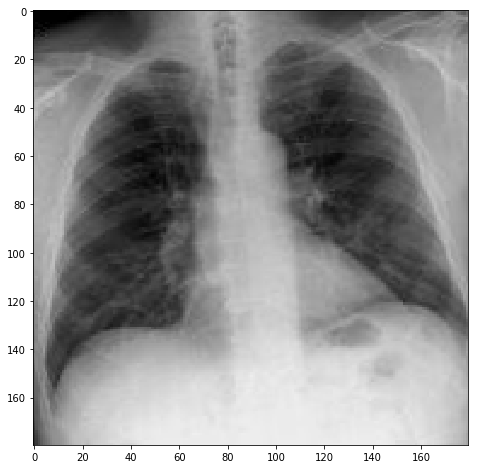

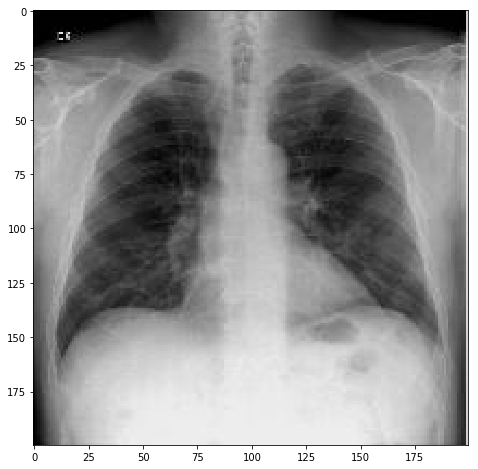

In [97]:
fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(8,8))#,
plt.imshow(d[5])
fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(8,8))#,
plt.imshow(X_test[diseaseID_test==1][5])

In [16]:
X_train_news = new_pictures_arrays(X_train[diseaseID_train==1])
X_train_news.shape

(2175, 180, 180, 3)

In [17]:
"""
News images to train 
"""
X_train_news = new_pictures_arrays(X_train[diseaseID_train==1])
print(X_train_news.shape)
diseaseID_train_news = np.ones(X_train_news.shape[0])
print(diseaseID_train_news.shape)
X_train = X_train[:,10:190,10:190]
X_train = np.concatenate([X_train,X_train_news],axis=0)
diseaseID_train = np.concatenate([diseaseID_train,diseaseID_train_news],axis=0)
del X_train_news, diseaseID_train_news
print(X_train.shape)
print(diseaseID_train.shape)

(2175, 180, 180, 3)
(2175,)
(18749, 180, 180, 3)
(18749,)


In [18]:
"""
News images to test 
"""
X_test_news = new_pictures_arrays(X_test[diseaseID_test==1])
print(X_test_news.shape)
diseaseID_test_news = np.ones(X_test_news.shape[0])
print(diseaseID_test_news.shape)
X_test = X_test[:,10:190,10:190]
X_test = np.concatenate([X_test,X_test_news],axis=0)
diseaseID_test = np.concatenate([diseaseID_test,diseaseID_test_news],axis=0)
del X_test_news, diseaseID_test_news
print(X_test.shape)
print(diseaseID_test.shape)

(250, 180, 180, 3)
(250,)
(2203, 180, 180, 3)
(2203,)


In [ ]:
40//

In [ ]:
from scipy import ndimage
a = X_test[0]
print(a.shape)
a=a.reshape(180,180)
lx,ly =a.shape
fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(8,8))#,
rotate_face = ndimage.rotate(a, 8)
plt.imshow(rotate_face)

## Imbalanced methods
We reduce the NO-COVID images and create new COVID images with the SMOTE Algorithm

In [19]:
from collections import Counter
counter = Counter (diseaseID_train)
print(counter)

Counter({2.0: 8521, 0.0: 7966, 1.0: 2262})


In [20]:
dicto = {2: 3000, 0: 3000, 1:2262}
dicto

{0: 3000, 1: 2262, 2: 3000}

In [21]:
X_train = X_train.reshape(X_train.shape[0],-1)
print(X_train.shape)

(18749, 97200)


In [22]:
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler

under = RandomUnderSampler(sampling_strategy =dicto)
X_train, diseaseID_train = under.fit_resample(X_train, diseaseID_train)
# summarize class distribution
print(diseaseID_train.shape)
print(X_train.shape)

(8262,)
(8262, 97200)


In [23]:
Y_train = np.copy(diseaseID_train)
Y_train[Y_train==2]=0
Y_test = np.copy(diseaseID_test)
Y_test[Y_test==2]=0

In [24]:
from imblearn.over_sampling import SMOTE
oversample = SMOTE(sampling_strategy=0.4)
X_train, Y_train = oversample.fit_resample(Xnew, Y_train)
# summarize class distribution
counter = Counter(Y_train)
print(counter)

NameError: name 'Xnew' is not defined

In [ ]:
X_test = X_test.reshape(X_test.shape[0],-1)
print(X_test.shape)

In [ ]:
oversample = SMOTE(sampling_strategy=0.3)
X_test,Y_test = oversample.fit_sample(X_test, Y_test)
# summarize class distribution
counter = Counter(Y_test)
print(counter)

In [26]:
X_train = X_train.reshape(X_train.shape[0],180,180,3)
X_test = X_test.reshape(X_test.shape[0],180,180,3)
Y_train = Y_train.reshape(Y_train.shape[0],1)
Y_test = Y_test.reshape(Y_test.shape[0],1)
X_test =  X_test/255

In [27]:
X_train = X_train/255

## Deep model

In [28]:
def inception_block (previous_layer,filters =[64,128,32,32]):
    conv1x1 = Conv2D(filters=filters[0], kernel_size=(1,1), activation='relu')(previous_layer)
    conv1x1_2 = Conv2D(filters=filters[1], kernel_size=(1,1), activation='relu')(previous_layer)
    conv1x1_3 = Conv2D(filters=filters[2], kernel_size=(1,1), activation='relu')(previous_layer)
    conv3x3 = Conv2D(filters=filters[1], kernel_size=(3,3), activation='relu',padding="same")(conv1x1_2)
    conv5x5 = Conv2D(filters=filters[2], kernel_size=(5,5), activation='relu',padding="same")(conv1x1_3)
    max_pool= MaxPooling2D(pool_size=(3,3),padding="same",strides=1)(previous_layer)
    conv_max = Conv2D(filters=filters[3], kernel_size=(1,1), activation='relu',padding="same")(max_pool)
    inception = concatenate([conv1x1, conv3x3,conv5x5,conv_max])
    return inception

In [49]:
"""
Incep_5 archiquecture using Functional api
"""
input_layer = Input(shape= (180,180,3,))
inception_1 = inception_block(input_layer,filters =[16,32,8,8])
pool_1 = MaxPooling2D()(inception_1)
inception_2 = inception_block(pool_1,filters =[32,64,16,16])
pool_2 = MaxPooling2D()(inception_2)
inception_3 = inception_block(pool_2)
pool_3= MaxPooling2D()(inception_3)
inception_4 = inception_block(pool_3)
pool_4= MaxPooling2D()(inception_4)
inception_5 = inception_block(pool_4,filters =[128,256,64,64])
pool_5 = MaxPooling2D(pool_size= (2,2))(inception_5)
inception_6 = inception_block(pool_5,filters =[128,256,64,64])
pool_6= MaxPooling2D(pool_size= (5,5))(inception_6)
conv_FC = Conv2D(filters =128,kernel_size =(1,1),activation="relu")(pool_6)
first_dense = Conv2D(filters =32,kernel_size =(1,1),activation="relu")(conv_FC)
#sec_dense = Conv2D(filters =16,kernel_size =(1,1),activation="relu")(first_dense)
flat = Flatten()(first_dense)
out_layer= Dense(units =1, activation= "sigmoid")(flat)
deep = Model(inputs=input_layer, outputs=out_layer)


deep.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 180, 180, 3)  0                                            
__________________________________________________________________________________________________
conv2d_78 (Conv2D)              (None, 180, 180, 32) 128         input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_79 (Conv2D)              (None, 180, 180, 8)  32          input_3[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_25 (MaxPooling2D) (None, 180, 180, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_77 

In [50]:
print('Train shape X: {},  Y: {} \n Test shape X: {}, Y: {}'.format(X_train.shape, Y_train.shape, X_test.shape, Y_test.shape))

Train shape X: (8262, 180, 180, 3),  Y: (8262, 1) 
 Test shape X: (2203, 180, 180, 3), Y: (2203, 1)


In [51]:
from keras.callbacks import ModelCheckpoint

filepath="Inception_bestmodel_trained.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

deep.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc',"mse"])
history = deep.fit(X_train, Y_train, epochs=12, batch_size=32, callbacks= [checkpoint],verbose=2, validation_data=(X_test, Y_test))


Train on 8262 samples, validate on 2203 samples
Epoch 1/12
 - 41s - loss: 0.4194 - acc: 0.8068 - mean_squared_error: 0.1354 - val_loss: 0.2966 - val_acc: 0.8593 - val_mean_squared_error: 0.0951

Epoch 00001: val_acc improved from -inf to 0.85928, saving model to Inception_bestmodel_trained.hdf5
Epoch 2/12
 - 35s - loss: 0.2434 - acc: 0.8994 - mean_squared_error: 0.0742 - val_loss: 0.2989 - val_acc: 0.8829 - val_mean_squared_error: 0.0895

Epoch 00002: val_acc improved from 0.85928 to 0.88289, saving model to Inception_bestmodel_trained.hdf5
Epoch 3/12
 - 35s - loss: 0.1475 - acc: 0.9408 - mean_squared_error: 0.0433 - val_loss: 0.3134 - val_acc: 0.8779 - val_mean_squared_error: 0.0915

Epoch 00003: val_acc did not improve
Epoch 4/12
 - 35s - loss: 0.0903 - acc: 0.9648 - mean_squared_error: 0.0253 - val_loss: 0.2617 - val_acc: 0.9156 - val_mean_squared_error: 0.0692

Epoch 00004: val_acc improved from 0.88289 to 0.91557, saving model to Inception_bestmodel_trained.hdf5
Epoch 5/12
 - 35s 

In [36]:
pred = deep.predict(X_test)
pred.shape

(2203, 1)

In [52]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresold = roc_curve(Y_test,pred)
roc_auc = auc(fpr,tpr)
print(roc_auc)

0.960582366681183


In [53]:
from keras.models import load_model
model = load_model("Inception_bestmodel_trained.hdf5")
pred_best = model.predict(X_test)

In [54]:
from sklearn.metrics import confusion_matrix
cm= confusion_matrix(Y_test, pred.round())
print(cm)
print("Best model")
cm= confusion_matrix(Y_test, pred_best.round())
print(cm)

[[1919   24]
 [ 154  106]]
Best model
[[1898   45]
 [ 121  139]]


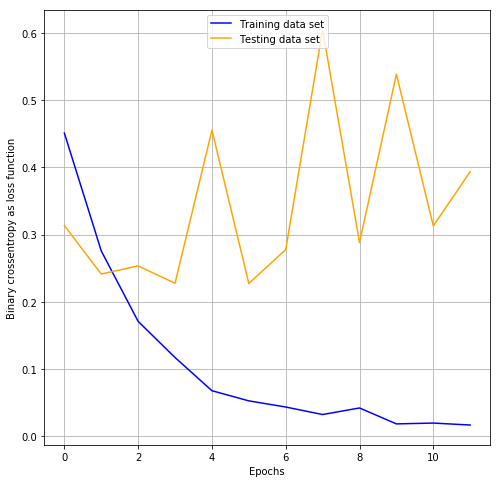

In [43]:
fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(8,8))#,6

plt.grid(True)
plt.plot(history.history["loss"], color="blue", label="Training data set")
plt.plot(history.history["val_loss"], color="orange", label="Testing data set")
plt.ylabel('Binary crossentropy as loss function')
plt.xlabel('Epochs')
plt.legend(loc='upper center')
plt.show()

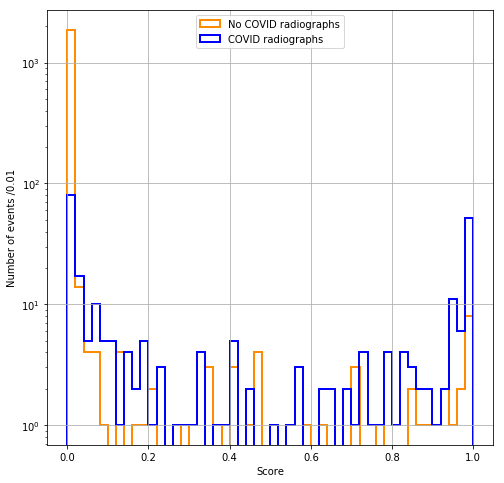

In [59]:
fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(8,8))#,6
plt.style.use('seaborn-deep') 
plt.grid(True)

lw=2
plt.hist(pred[(Y_test==0)],50,histtype='step',lw=lw,color='darkorange', label= "No COVID radiographs")
plt.hist(pred[(Y_test==1)],50,histtype='step',lw=lw,color='blue', label= "COVID radiographs")
plt.ylabel('Number of events /0.01')
plt.xlabel('Score')
plt.yscale("log")
plt.legend( loc='upper center')
plt.show()

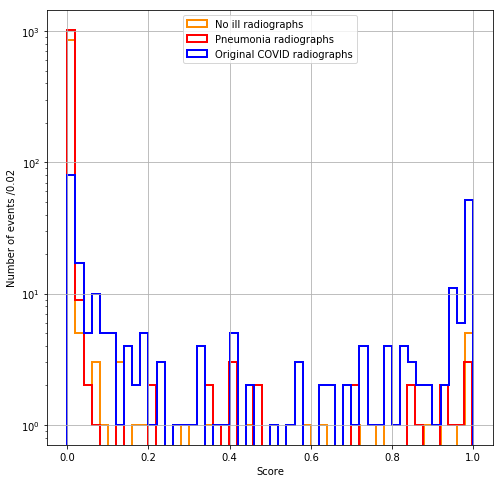

In [56]:
fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(8,8))#,6
plt.style.use('seaborn-deep') 
plt.grid(True)

lw=2
plt.hist(pred[(diseaseID_test==0)],50,histtype='step',lw=lw,color='darkorange', label= "No ill radiographs")
plt.hist(pred[(diseaseID_test==2)],50,histtype='step',lw=lw,color='red', label= "Pneumonia radiographs")
plt.hist(pred[(diseaseID_test==1)],50,histtype='step',lw=lw,color='blue', label= "Original COVID radiographs")
#plt.hist(pred[1953:],50,histtype='step',lw=lw,color='green', label= "Created COVID radiographs")

plt.ylabel('Number of events /0.02')
plt.xlabel('Score')
plt.yscale("log")
plt.legend( loc='upper center')
plt.show()

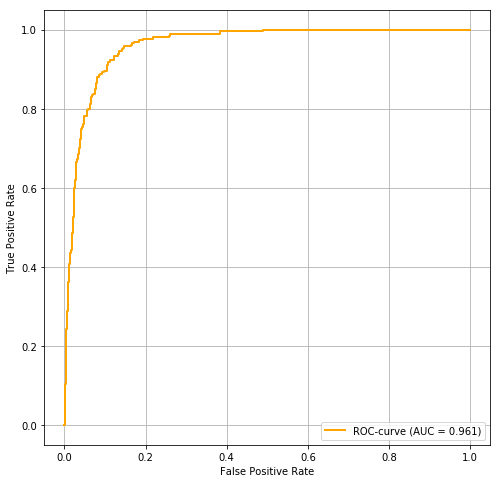

In [55]:
fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(8,8))#,6
plt.style.use('seaborn-deep') 
#plt.title("Simulation", weight="bold", x=0.50)
plt.grid(True)
#yticks(np.arange(0.97, 1, step=0.005))
lw = 2
plt.plot(fpr, tpr, color='orange',lw=2, label='ROC-curve (AUC = %0.3f)' % (roc_auc))


plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

#plt.title("Simulation Preliminary", color = '#e159e1',loc="left", weight="bold", size="large")
plt.legend(loc="lower right")
plt.show()